In [1]:
import pdb

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import time
from datetime import timedelta
import numpy as np
import os
from PIL import Image, ImageChops, ImageOps

# Functions and classes for loading and using the Inception model.
import inception
import prettytensor as pt

In [25]:
def padd_an_image(image, size):
    image_size = image.size
    padded_image = image.crop((0, 0, size[0], size[1]))
    offset_x = max((size[0] - image_size[0])/2, 0)
    offset_y = max((size[1] - image_size[1])/2, 0)
    padded_image = ImageChops.offset(padded_image, int(offset_x), int(offset_y))
    return padded_image
    
def crop_an_image(image, size):
    cropped_image = ImageOps.fit(image, size, Image.ANTIALIAS, (0.5, 0.5))
    return cropped_image
    
def resize_images(f_in, f_out, size=(80,80), pad=False):
    if f_out.find('.jpg')!=-1:
        f_out = f_out.split('/')
        image_o = f_out[len(f_out)-1]
        f_out = '/'.join(f_out[1:(len(f_out)-1)])
        f_out= '/'+f_out+'/'        
    if not os.path.isdir(f_out):
        print('Se crea el directorio %s' % f_out)
        os.mkdir(f_out)
    else:
        print('El directorio %s ya existe' % f_out)
    set_of_resized_images = os.listdir(f_out)
    if len(set_of_resized_images)>0:
        print('Hay imagenes')
        set_of_padded = []
        set_of_resized_images.sort()
        for image_r in set_of_resized_images:
            image_file = os.path.join(f_out, image_r)
            image_o = Image.open(image_file)
            image_o.thumbnail(size, Image.ANTIALIAS) 
            set_of_padded.append(np.array(image_o))
            image_o.close()                
            if len(set_of_padded) % 500 == 0:
                print('%d imagenes de %d' % (len(set_of_padded), len(set_of_resized_images)))
            if len(set_of_padded) == len(set_of_resized_images):
                    print('Imagenes 100% cargadas')
        return set_of_padded
    else:
        print('No hay imagenes en el directorio')
        if os.path.isdir(f_in): 
            set_of_images = os.listdir(f_in)
            set_of_padded = []
            set_of_images.sort()
            for image_i in set_of_images:
                image_file = os.path.join(f_in, image_i)
                image = Image.open(image_file)
                image.thumbnail(size, Image.ANTIALIAS)
                if pad:
                    image_o = padd_an_image(image, size)
                else:
                    image_o = crop_an_image(image, size)
                image_out = os.path.join(f_out, image_i)   
                image_o.save(image_out)
                set_of_padded.append(np.array(image_o))
                if len(set_of_padded)%500 == 0:
                    print('%d imagenes de %d' % (len(set_of_padded), len(set_of_images)))
                if len(set_of_padded) == len(set_of_images):
                    print('Imagenes 100% completas')
            return set_of_padded
        else:            
            image = Image.open(f_in)
            image.thumbnail(size, Image.ANTIALIAS)
            if pad:
                thumb = padd_an_image(image, size)
            else:
                thumb = crop_an_image(image, size)
            image_o = os.path.join(f_out, image_o)
            thumb.save(image_o)
            return np.array(thumb)
            

In [26]:
image_source = '/home/juanmanuel/Descargas/VOCdevkit/VOC2012/JPEGImages/'
image_result = '/home/juanmanuel/new_images/'
set_of_images = []
set_of_images = resize_images(image_source, image_result, size=(254,254), pad=True)


Se crea el directorio /home/juanmanuel/new_images/
No hay imagenes en el directorio
500 imagenes de 17125
1000 imagenes de 17125
1500 imagenes de 17125
2000 imagenes de 17125
2500 imagenes de 17125
3000 imagenes de 17125
3500 imagenes de 17125
4000 imagenes de 17125
4500 imagenes de 17125
5000 imagenes de 17125
5500 imagenes de 17125
6000 imagenes de 17125
6500 imagenes de 17125
7000 imagenes de 17125
7500 imagenes de 17125
8000 imagenes de 17125
8500 imagenes de 17125
9000 imagenes de 17125
9500 imagenes de 17125
10000 imagenes de 17125
10500 imagenes de 17125
11000 imagenes de 17125
11500 imagenes de 17125
12000 imagenes de 17125
12500 imagenes de 17125
13000 imagenes de 17125
13500 imagenes de 17125
14000 imagenes de 17125
14500 imagenes de 17125
15000 imagenes de 17125
15500 imagenes de 17125
16000 imagenes de 17125
16500 imagenes de 17125
17000 imagenes de 17125
Imagenes 100% completas


In [1]:
def image_sizes(f_in, f_out):
    set_images = os.listdir(f_in)
    set_padd_images = os.listdir(f_out)
    if os.path.isdir(f_out) and os.path.isdir(f_in):        
        for i in range(len(os.listdir(f_in))):
            image_i = Image.open(os.path.join(f_in, set_images[i]))
            image_o = Image.open(os.path.join(f_out, set_padd_images[i]))
            print(image_i.size, image_o.size)

In [ ]:
image_source = '/home/juanmanuel/Descargas/VOCdevkit/VOC2012/JPEGImages/'
image_result = '/home/juanmanuel/new_images/'
image_sizes(image_source, image_result)

In [28]:
def xmlFile_to_oneHot(xml_path, classes):    
    xml_files = os.listdir(xml_path)
    xml_files.sort()
    one_h_vec_file = np.empty((0, len(classes)))
    cls_label_file = []
    for file in xml_files:
        cls_in_file = ''
        one_h_vec = np.zeros((1, len(classes)))
        file = os.path.join(xml_path, file)
        with open(file, 'r') as infile:
            for line in infile:
                if line[:8] == '\t\t<name>':
                    for cls in classes:
                        if line.find(cls) != -1:
                            cls_in_file = cls
                            break
                    break            
            for i in range(len(classes)):
                if cls_in_file == classes[i]:
                    one_h_vec[0][i] = 1.0
                    cls_label = i
                    break
            one_h_vec_file = np.append(one_h_vec_file, one_h_vec, axis=0)
            cls_label_file.append(cls_label)
            if len(one_h_vec_file)%500 == 0:
                print('%d 1HV de %d' % (len(one_h_vec_file), len(xml_files)))
            if len(one_h_vec_file) == len(xml_files):
                print('100% completado')
    return cls_label_file, one_h_vec_file
 

In [78]:
path_xml_files = '/home/juanmanuel/Descargas/VOCdevkit/VOC2012/Annotations/'
classes = ['aeroplane','bicycle','bird','boat','bottle','bus','car',\
           'cat','chair','cow','diningtable','dog','horse','motorbike',\
           'person','pottedplant','sheep','sofa','train','tvmonitor']
cls, labels = xmlFile_to_oneHot(path_xml_files, classes)

cls_train = cls[:14000]
cls_test = cls[14000:]
labels_train = labels[:14000]
labels_test = labels[14000:]


500 1HV de 17125
1000 1HV de 17125
1500 1HV de 17125
2000 1HV de 17125
2500 1HV de 17125
3000 1HV de 17125
3500 1HV de 17125
4000 1HV de 17125
4500 1HV de 17125
5000 1HV de 17125
5500 1HV de 17125
6000 1HV de 17125
6500 1HV de 17125
7000 1HV de 17125
7500 1HV de 17125
8000 1HV de 17125
8500 1HV de 17125
9000 1HV de 17125
9500 1HV de 17125
10000 1HV de 17125
10500 1HV de 17125
11000 1HV de 17125
11500 1HV de 17125
12000 1HV de 17125
12500 1HV de 17125
13000 1HV de 17125
13500 1HV de 17125
14000 1HV de 17125
14500 1HV de 17125
15000 1HV de 17125
15500 1HV de 17125
16000 1HV de 17125
16500 1HV de 17125
17000 1HV de 17125
100% completado


In [9]:
def plot_images(images, cls_true, cls_pred=None, smooth=True):

    assert len(images) == len(cls_true)

    # Create figure with sub-plots.
    fig, axes = plt.subplots(3, 3)

    # Adjust vertical spacing.
    if cls_pred is None:
        hspace = 0.3
    else:
        hspace = 0.6
    fig.subplots_adjust(hspace=hspace, wspace=0.3)

    # Interpolation type.
    if smooth:
        interpolation = 'spline16'
    else:
        interpolation = 'nearest'

    for i, ax in enumerate(axes.flat):
        # There may be less than 9 images, ensure it doesn't crash.
        if i < len(images):
            # Plot image.
            ax.imshow(images[i],
                      interpolation=interpolation)

            # Name of the true class.
            cls_true_name = classes[cls_true[i]]

            # Show true and predicted classes.
            if cls_pred is None:
                xlabel = "True: {0}".format(cls_true_name)
            else:
                # Name of the predicted class.
                cls_pred_name = classes[cls_pred[i]]

                xlabel = "True: {0}\nPred: {1}".format(cls_true_name, cls_pred_name)

            # Show the classes as the label on the x-axis.
            ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

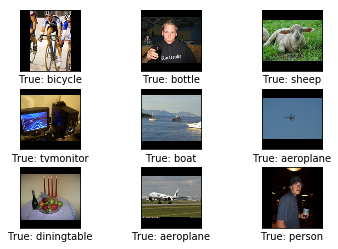

In [12]:
example_images = set_of_images[10:19]
example_lables = lables_class[10:19]
plot_images(images=example_images, cls_true=example_lables, smooth=False)


In [30]:
new_data_path = 'new_data/'
file_path_cache_train = os.path.join(new_data_path , 'new_data_train.pkl')
file_path_cache_test = os.path.join(new_data_path , 'new_data_test.pkl')

In [36]:
images_train = set_of_images[:14000]
images_test = set_of_images[14000:]

In [32]:
inception.data_dir = 'inception/'
inception.maybe_download()

Data has apparently already been downloaded and unpacked.


In [37]:
model = inception.Inception()

In [38]:
from inception import transfer_values_cache

In [39]:
print("Processing Inception transfer-values for training-images ...")

# Scale images because Inception needs pixels to be between 0 and 255,
# while the CIFAR-10 functions return pixels between 0.0 and 1.0
images_scaled = images_train

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_train = transfer_values_cache(cache_path=file_path_cache_train,
                                              images=images_scaled,
                                              model=model)

Processing Inception transfer-values for training-images ...
- Processing image:  14000 / 14000
- Data saved to cache-file: new_data/new_data_train.pkl


In [40]:
print("Processing Inception transfer-values for test-images ...")

# Scale images because Inception needs pixels to be between 0 and 255,
# while the CIFAR-10 functions return pixels between 0.0 and 1.0
images_scaled = images_test

# If transfer-values have already been calculated then reload them,
# otherwise calculate them and save them to a cache-file.
transfer_values_test = transfer_values_cache(cache_path=file_path_cache_test,
                                             images=images_scaled,
                                             model=model)

Processing Inception transfer-values for test-images ...
- Processing image:   3125 / 3125
- Data saved to cache-file: new_data/new_data_test.pkl


In [79]:
transfer_values_test.shape

(3125, 2048)

In [80]:
transfer_values_train.shape

(14000, 2048)

In [81]:
def plot_transfer_values(i):
    print("Input image:")
    
    # Plot the i'th image from the test-set.
    plt.imshow(images_test[i], interpolation='nearest')
    plt.show()

    print("Transfer-values for the image using Inception model:")
    
    # Transform the transfer-values into an image.
    img = transfer_values_test[i]
    img = img.reshape((32, 64))

    # Plot the image for the transfer-values.
    plt.imshow(img, interpolation='nearest', cmap='Reds')
    plt.show()

Input image:


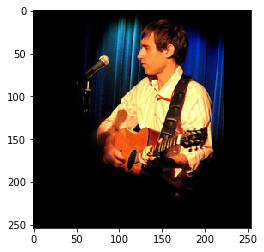

Transfer-values for the image using Inception model:


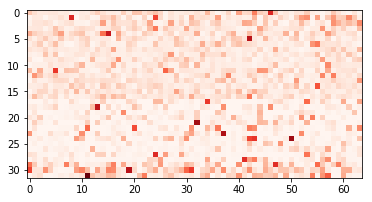

In [82]:
plot_transfer_values(i=16)

Input image:


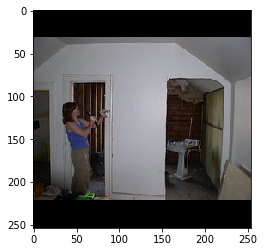

Transfer-values for the image using Inception model:


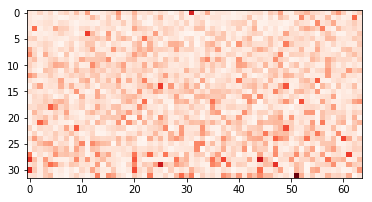

In [83]:
plot_transfer_values(i=10)

In [84]:
from sklearn.manifold import TSNE

In [85]:
from sklearn.decomposition import PCA

In [86]:
transfer_values = transfer_values_train[0:3000]
pca = PCA(n_components=50)
transfer_values_50d = pca.fit_transform(transfer_values)

In [87]:
tsne = TSNE(n_components=2)

In [88]:
transfer_values_reduced = tsne.fit_transform(transfer_values_50d) 

In [89]:
def plot_scatter(values, cls):
    # Create a color-map with a different color for each class.
    import matplotlib.cm as cm
    cmap = cm.rainbow(np.linspace(0.0, 1.0, num_classes))

    # Get the color for each sample.
    colors = cmap[cls]

    # Extract the x- and y-values.
    x = values[:, 0]
    y = values[:, 1]

    # Plot it.
    plt.scatter(x, y, color=colors)
    plt.show()

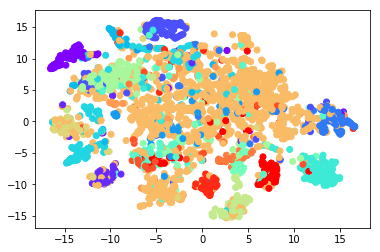

In [90]:
num_classes = len(classes)
cls = cls_train[0:3000]
plot_scatter(transfer_values_reduced, cls)

In [91]:
transfer_len = model.transfer_len

In [92]:
x = tf.placeholder(tf.float32, shape=[None, transfer_len], name='x')
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')
y_true_cls = tf.argmax(y_true, dimension=1)

In [93]:
x_pretty = pt.wrap(x)

with pt.defaults_scope(activation_fn=tf.nn.relu):
    y_pred, loss = x_pretty.\
        fully_connected(size=1024, name='layer_fc1').\
        softmax_classifier(num_classes=num_classes, labels=y_true)

In [94]:
global_step = tf.Variable(initial_value=0,
                          name='global_step', trainable=False)

In [95]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(loss, global_step)

In [96]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

In [97]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [98]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [99]:
session = tf.Session()

In [100]:
session.run(tf.global_variables_initializer())

In [101]:
train_batch_size = 64

In [102]:
def random_batch():
    # Number of images (transfer-values) in the training-set.
    num_images = len(transfer_values_train)

    # Create a random index.
    idx = np.random.choice(num_images,
                           size=train_batch_size,
                           replace=False)
    
    # Use the random index to select random x and y-values.
    # We use the transfer-values instead of images as x-values.
    x_batch = transfer_values_train[idx]
    y_batch = labels_train[idx]

    return x_batch, y_batch

In [103]:
def optimize(num_iterations):
    # Start-time used for printing time-usage below.
    start_time = time.time()

    for i in range(num_iterations):
        # Get a batch of training examples.
        # x_batch now holds a batch of images (transfer-values) and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch = random_batch()

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        # We also want to retrieve the global_step counter.
        i_global, _ = session.run([global_step, optimizer],
                                  feed_dict=feed_dict_train)

        # Print status to screen every 100 iterations (and last).
        if (i_global % 100 == 0) or (i == num_iterations - 1):
            # Calculate the accuracy on the training-batch.
            batch_acc = session.run(accuracy,
                                    feed_dict=feed_dict_train)

            # Print status.
            msg = "Global Step: {0:>6}, Training Batch Accuracy: {1:>6.1%}"
            print(msg.format(i_global, batch_acc))

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time usage: " + str(timedelta(seconds=int(round(time_dif)))))

In [104]:
def plot_example_errors(cls_pred, correct):
    # This function is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = images_test[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = cls_test[incorrect]

    n = min(9, len(images))
    
    # Plot the first n images.
    plot_images(images=images[0:n],
                cls_true=cls_true[0:n],
                cls_pred=cls_pred[0:n])

In [105]:
# Import a function from sklearn to calculate the confusion-matrix.
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cls_pred):
    # This is called from print_test_accuracy() below.

    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_test,  # True class for test-set.
                          y_pred=cls_pred)  # Predicted class.

    # Print the confusion matrix as text.
    for i in range(num_classes):
        # Append the class-name to each line.
        class_name = "({}) {}".format(i, classes[i])
        print(cm[i, :], class_name)

    # Print the class-numbers for easy reference.
    class_numbers = [" ({0})".format(i) for i in range(num_classes)]
    print("".join(class_numbers))

In [106]:
# Split the data-set in batches of this size to limit RAM usage.
batch_size = 256

def predict_cls(transfer_values, labels, cls_true):
    # Number of images.
    num_images = len(transfer_values)

    # Allocate an array for the predicted classes which
    # will be calculated in batches and filled into this array.
    cls_pred = np.zeros(shape=num_images, dtype=np.int)

    # Now calculate the predicted classes for the batches.
    # We will just iterate through all the batches.
    # There might be a more clever and Pythonic way of doing this.

    # The starting index for the next batch is denoted i.
    i = 0

    while i < num_images:
        # The ending index for the next batch is denoted j.
        j = min(i + batch_size, num_images)

        # Create a feed-dict with the images and labels
        # between index i and j.
        feed_dict = {x: transfer_values[i:j],
                     y_true: labels[i:j]}

        # Calculate the predicted class using TensorFlow.
        cls_pred[i:j] = session.run(y_pred_cls, feed_dict=feed_dict)

        # Set the start-index for the next batch to the
        # end-index of the current batch.
        i = j
        
    # Create a boolean array whether each image is correctly classified.
    correct = (cls_true == cls_pred)

    return correct, cls_pred

In [107]:
def predict_cls_test():
    return predict_cls(transfer_values = transfer_values_test,
                       labels = labels_test,
                       cls_true = cls_test)

In [108]:
def classification_accuracy(correct):
    # When averaging a boolean array, False means 0 and True means 1.
    # So we are calculating: number of True / len(correct) which is
    # the same as the classification accuracy.

    # Return the classification accuracy
    # and the number of correct classifications.
    return correct.mean(), correct.sum()

In [109]:
def print_test_accuracy(show_example_errors=False,
                        show_confusion_matrix=False):

    # For all the images in the test-set,
    # calculate the predicted classes and whether they are correct.
    correct, cls_pred = predict_cls_test()
    
    # Classification accuracy and the number of correct classifications.
    acc, num_correct = classification_accuracy(correct)
    
    # Number of images being classified.
    num_images = len(correct)

    # Print the accuracy.
    msg = "Accuracy on Test-Set: {0:.1%} ({1} / {2})"
    print(msg.format(acc, num_correct, num_images))

    # Plot some examples of mis-classifications, if desired.
    if show_example_errors:
        print("Example errors:")
        plot_example_errors(cls_pred=cls_pred, correct=correct)

    # Plot the confusion matrix, if desired.
    if show_confusion_matrix:
        print("Confusion Matrix:")
        plot_confusion_matrix(cls_pred=cls_pred)

In [110]:
print_test_accuracy(show_example_errors=False,
                    show_confusion_matrix=False)

Accuracy on Test-Set: 0.0% (0 / 3125)


In [111]:
optimize(num_iterations=10000)

Global Step:    100, Training Batch Accuracy:  68.8%
Global Step:    200, Training Batch Accuracy:  75.0%
Global Step:    300, Training Batch Accuracy:  76.6%
Global Step:    400, Training Batch Accuracy:  85.9%
Global Step:    500, Training Batch Accuracy:  79.7%
Global Step:    600, Training Batch Accuracy:  75.0%
Global Step:    700, Training Batch Accuracy:  89.1%
Global Step:    800, Training Batch Accuracy:  89.1%
Global Step:    900, Training Batch Accuracy:  84.4%
Global Step:   1000, Training Batch Accuracy:  85.9%
Global Step:   1100, Training Batch Accuracy:  79.7%
Global Step:   1200, Training Batch Accuracy:  81.2%
Global Step:   1300, Training Batch Accuracy:  85.9%
Global Step:   1400, Training Batch Accuracy:  85.9%
Global Step:   1500, Training Batch Accuracy:  85.9%
Global Step:   1600, Training Batch Accuracy:  81.2%
Global Step:   1700, Training Batch Accuracy:  82.8%
Global Step:   1800, Training Batch Accuracy:  85.9%
Global Step:   1900, Training Batch Accuracy: 

In [112]:
print_test_accuracy(show_example_errors=True,
                    show_confusion_matrix=True)

Accuracy on Test-Set: 81.7% (2553 / 3125)
Example errors:


TypeError: only integer scalar arrays can be converted to a scalar index